# ЧАСТЬ №1. ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ ФОНДОВОГО РЫНКА.

 <b>рынок:</b> Бразилия<br>
 <b>период:</b> 2018 год

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("..\data_log_return.csv")
tickers = list(data.columns)
tickers.pop(0)

'Date'

# 1. Оценка ожидаемых доходностей и стандартных отклонений.

Для того, чтобы оценить ожидаемые доходности и стандартные отклонения мы используем функции mean() и std(). В нашей табличке уже есть логарифмические доходности по дням для каждой акции. Именно их мы и будем использовать для подсчетов.

In [2]:
# Вычисление оценки ожидаемых доходностей и стандартных отклонений
def find_E_n_sigma(data, tickers):
    expected_returns = {}
    risks = {}

    for ticker in tickers:
        risk = data[ticker].std()
        expected_returns[ticker] = data[ticker].mean()
        risks[ticker] = risk

    risk_and_return = pd.DataFrame({
        'Ticker': expected_returns.keys(),
        'E': expected_returns.values(),
        'σ': risks.values()
    })

    return risk_and_return

risk_and_return = find_E_n_sigma(data, tickers)

Построем «карту» активов в системе координат (σ, E).

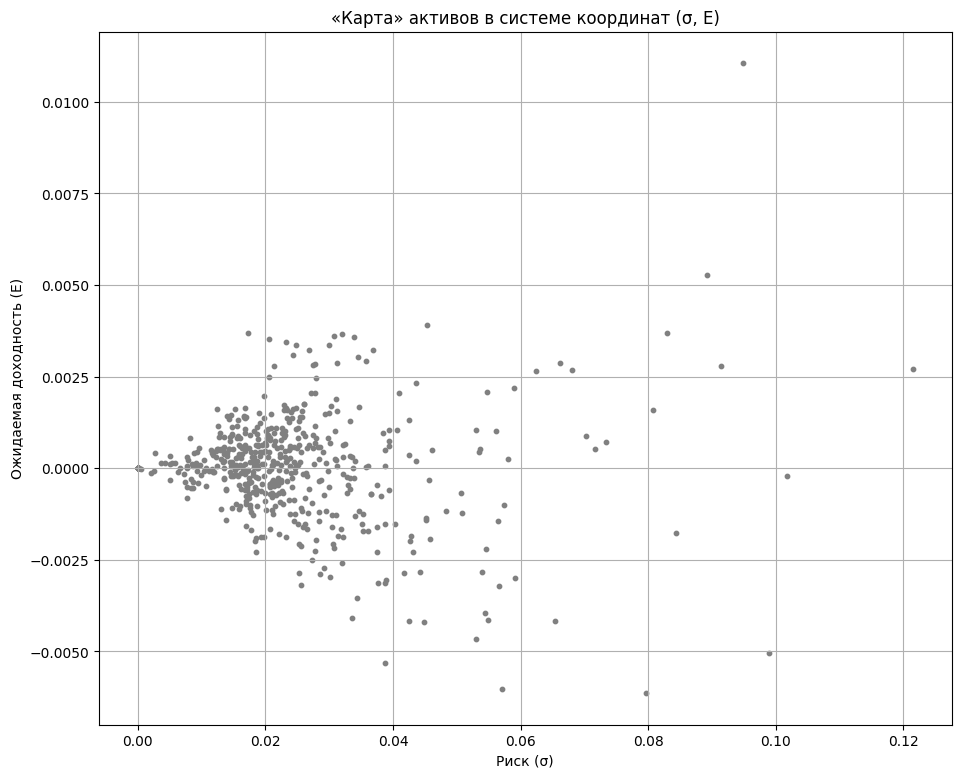

In [3]:
# Построение карты активов с выделенными выбранными.
plt.figure(figsize=(11, 9))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.grid()
plt.show()

# 2. Парето-оптимальные активы.

Парето-оптимальные активы - активы, характеристики которых нельзя улучшить сразу по двум критериям. Это значит, что нет активов у которых одновременно больше доходность и меньше риск.

In [4]:
# Функция для поиска Парето-оптимальных активов
pareto_optimal_assets = []

for i in range(len(risk_and_return['Ticker'])):
    current_E = risk_and_return['E'][i]
    current_Sigma = risk_and_return['σ'][i]
    is_optimal = True
    for j in range(len(risk_and_return['Ticker'])):
        if i != j:
            if (risk_and_return['E'][j] >= current_E and risk_and_return['σ'][j] <= current_Sigma):
                is_optimal = False
                break
    if is_optimal:
        pareto_optimal_assets.append(risk_and_return['Ticker'][i])

pareto_optimal = find_E_n_sigma(data, pareto_optimal_assets)
print(pareto_optimal)

      Ticker         E         σ
0   AZEV3.SA  0.005261  0.089274
1   CEGR3.SA  0.000819  0.008155
2   CPFE3.SA  0.001613  0.012433
3   EQPA6.SA  0.011053  0.094818
4   HETA3.SA  0.000010  0.000160
5   IRBR3.SA  0.003700  0.017212
6  LILY34.SA  0.001648  0.016880
7   LOGN3.SA  0.003912  0.045399
8  MRCK34.SA  0.001626  0.015278
9  NPAR11.SA  0.000408  0.002748


Всего у нас получилось 10 Парето-оптимальных активев. Теперь покажем их на общей карте.

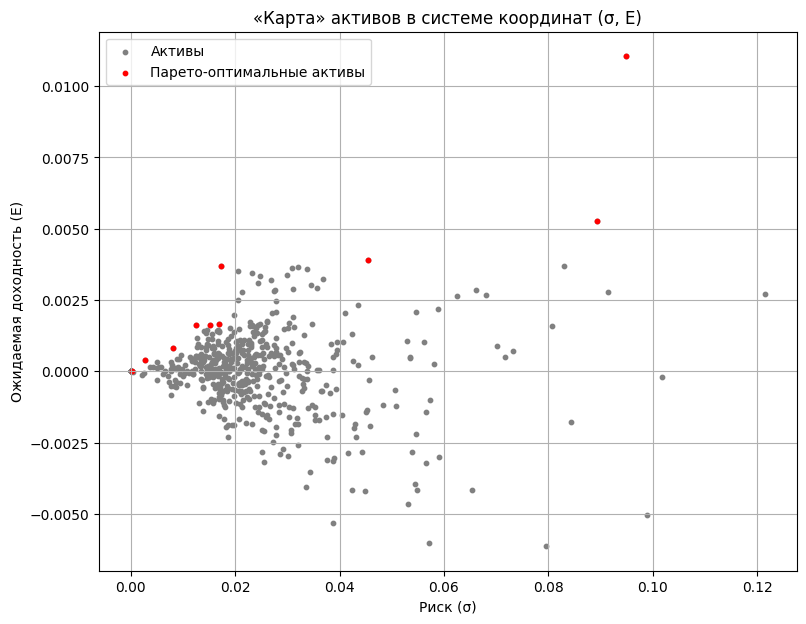

In [5]:
# Построение карты активов в системе координат (σ, E)
plt.figure(figsize=(9, 7))
plt.scatter(risk_and_return['σ'], risk_and_return['E'], s=10, color='grey', label='Активы')
plt.scatter(pareto_optimal['σ'], pareto_optimal['E'], s=10, color='red', label='Парето-оптимальные активы')
plt.title('«Карта» активов в системе координат (σ, E)')
plt.xlabel('Риск (σ)')
plt.ylabel('Ожидаемая доходность (E)')
plt.legend()
plt.grid()
plt.show()

# 3. Value at Risk и Conditional Value at Risk
### - Оценка VaR / CVaR с уровнем доверия 0,95 для Парето-оптимальных активов рынка.
### - Какие из активов наиболее предпочтительны по этим характеристикам?
### - Где они расположены на карте активов?
### - Сравнить результаты VaR и CVaR

Мы нашли Парето-оптимальные активы и теперь мы сделаем небольшую таблицу с логарифмическими доходностями для этих активов.

In [18]:
portfolio_returns = pd.DataFrame()
ticker_returns = pd.DataFrame()

for ticker in pareto_optimal_assets:
    ticker_returns['log_return'] = pd.DataFrame(data[ticker]).reset_index(drop=True)
    portfolio_returns[ticker] = ticker_returns['log_return']
portfolio_returns['Portfolio Returns'] = portfolio_returns.sum(axis=1)

print(portfolio_returns)

     AZEV3.SA  CEGR3.SA  CPFE3.SA  EQPA6.SA  HETA3.SA  IRBR3.SA  LILY34.SA  \
0         NaN       NaN       NaN       NaN       NaN       NaN        NaN   
1         0.0       0.0 -0.012429       0.0       0.0  0.000000  -0.022120   
2         0.0       0.0 -0.007322       0.0       0.0  0.008566   0.000361   
3         0.0       0.0 -0.016407       0.0       0.0  0.012858   0.008475   
4         0.0       0.0  0.015882       0.0       0.0  0.016129  -0.001646   
..        ...       ...       ...       ...       ...       ...        ...   
241       0.0       0.0  0.008332       0.0       0.0  0.008722  -0.008376   
242       0.0       0.0  0.009693       0.0       0.0  0.002354   0.028142   
243       0.0       0.0  0.007475       0.0       0.0 -0.001238  -0.025405   
244       0.0       0.0  0.009880       0.0       0.0  0.007407   0.000000   
245       0.0       0.0  0.012908       0.0       0.0  0.026221   0.000000   

     LOGN3.SA  MRCK34.SA  NPAR11.SA  Portfolio Returns  
0     

In [16]:
def historicalVaR(returns, alpha):

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha):

    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# 4. Распределение доходностей конкретного актива
### - Выбор нескольких интересных (значимых) активов рынка.
### - Можно ли считать наблюдаемые доходности конкретного актива повторной выборкой из некоторого распределения (белый шум)?
### - Поиск научных подходов к ответу на этот вопрос.

# 5. Нормальность распределений доходностей
### - Выбор нескольких интересных (значимых) активов рынка из разных производственных секторов.
### - В предположении, что наблюдаемые доходности являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей выбранных активов.
### - Можно ли считать, что распределения доходностей подчиняются нормальному закону распределения?
### - Если ответ отрицательный, какие другие законы распределения доходностей соответствуют данным наблюдений?


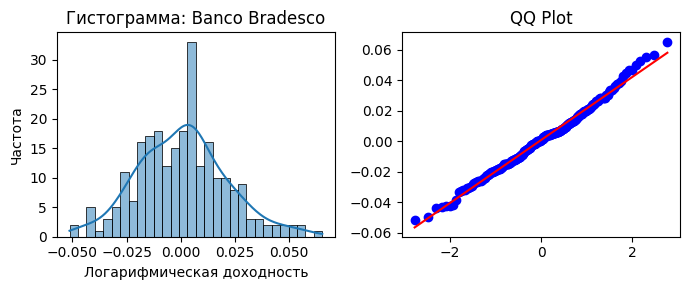

========== Banco Bradesco ======================================== 

Статистика = 0.9927924074809392, p-значение = 0.2833662546270422
Распределение логарифмических доходностей можно считать нормальным (p > 0.05) 



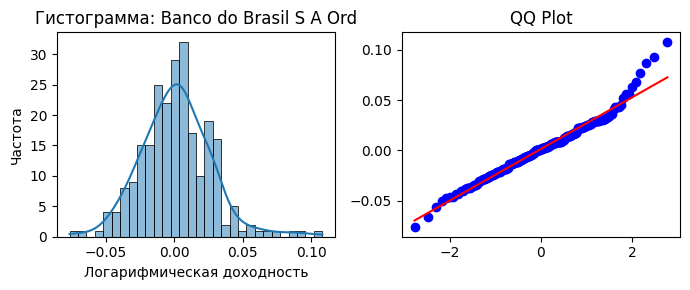

========== Banco do Brasil S A Ord ======================================== 

Статистика = 0.974777907655699, p-значение = 0.0002473038588551745
Распределение логарифмических доходностей не является нормальным (p <= 0.05) 



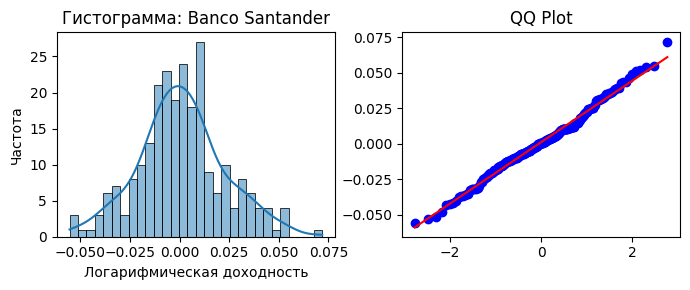

========== Banco Santander ======================================== 

Статистика = 0.9914441442533785, p-значение = 0.1656840027895783
Распределение логарифмических доходностей можно считать нормальным (p > 0.05) 



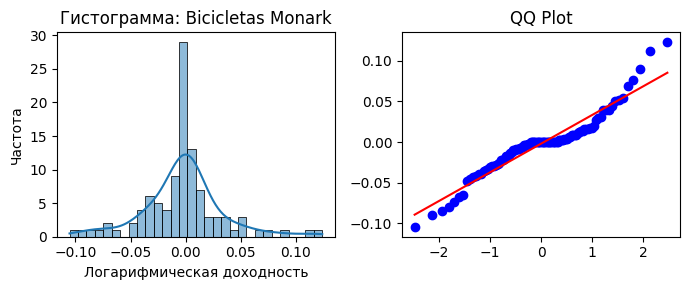

========== Bicicletas Monark ======================================== 

Статистика = 0.9227293149774158, p-значение = 1.3786628945379689e-05
Распределение логарифмических доходностей не является нормальным (p <= 0.05) 



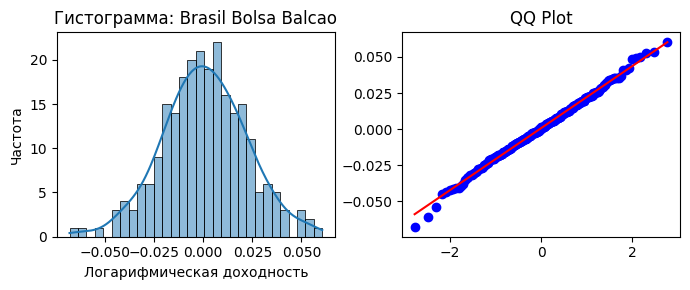

========== Brasil Bolsa Balcao ======================================== 

Статистика = 0.9970517918411603, p-значение = 0.9337716196190343
Распределение логарифмических доходностей можно считать нормальным (p > 0.05) 



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sheets = pd.ExcelFile('data.xlsx').sheet_names

for sheet in sheets[:5]:
    df = pd.read_excel('data.xlsx', sheet_name=sheet)

    log_returns = df['log_return'].dropna()  # Удаляем NaN, если они есть

    plt.figure(figsize=(7, 3))

    # Построение гистограммы
    plt.subplot(1, 2, 1)
    sns.histplot(log_returns, bins=30, kde=True)
    plt.title(f'Гистограмма: {sheet}')
    plt.xlabel('Логарифмическая доходность')
    plt.ylabel('Частота')

    # QQ plot
    plt.subplot(1, 2, 2)
    stats.probplot(log_returns, dist="norm", plot=plt)
    plt.title(f'QQ Plot')
    plt.xlabel('')
    plt.ylabel('')

    # Показ графиков
    plt.tight_layout()
    plt.show()

    # Тест Шапиро-Уилка

    print('='*10, sheet, '='*40, '\n')
    
    stat, p_value = stats.shapiro(log_returns)
    print(f'Статистика = {stat}, p-значение = {p_value}')
    if p_value > 0.05:
        print(f'Распределение логарифмических доходностей можно считать нормальным (p > 0.05) \n')
    else:
        print(f'Распределение логарифмических доходностей не является нормальным (p <= 0.05) \n')

# 6. Поиск чего-нибудь интересного (необычного) на рынке.